In [ ]:
# !pip install opencv-python

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import math
import random
from PIL import Image
from IPython.display import display

## First test

In [2]:
def poly_detection(img_path, tablas):
    inputImage = cv2.imread(img_path)
    inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(inputImageGray, 150, 200, apertureSize = 3)
    
    minLineLength = 500
    maxLineGap = -1
    
    for t in tablas:
        edges = cv2.rectangle(edges, t[:2], t[2:], color=(0,0,0), thickness=-1)
    
    display(Image.fromarray(edges))
    lines = cv2.HoughLinesP(edges,cv2.HOUGH_PROBABILISTIC, np.pi/180, 10, minLineLength, maxLineGap)
    
    return lines, inputImage

In [3]:
def apply_hough(img_path, tablas):
    lines, img1 = poly_detection(img_path, tablas)
    all_lines = {}
    for x in range(0, len(lines)):
        for i, (x1,y1,x2,y2) in enumerate(lines[x]):
            pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
            cv2.polylines(img1, [pts], True, (0,255,0))
            all_lines[str(x)+str(i)] = [[x1, y1 ], [x2 , y2]]
#         if x == 20:
#             break
    return Image.fromarray(img1), all_lines

In [4]:
def nearest_neighbour(p, points):
    dist_dict = {k: math.dist(p, v) for k,v in points.items()}
    return min(dist_dict, key=dist_dict.get),  min(dist_dict.values())

In [5]:
def get_key_to_unify(point, points, threshold=25):
    nearest_point, dst_point = nearest_neighbour(point, points)
    
    new = point
    key_to_unify = nearest_point.split("_")[0]
    if dst_point <= threshold:
        if "start" in nearest_point:
            nearest_point = key_to_unify + "_end"
        else:
            nearest_point = key_to_unify + "_start"
        new = points[nearest_point]
    else:
        return (None, None)
    
    # new -> [184, 204]
    # key_to_unify -> 20
    return new, key_to_unify

In [6]:
def validate_points(start, end, new_start, new_end):
    
    if new_start is None:
        new_start = start
    if new_end is None:
        new_end = end
    
    dif_start_x = abs(start[0]-new_start[0])
    dif_start_y = abs(start[1]-new_start[1])
    
    dif_end_x = abs(end[0]-new_end[0])
    dif_end_y = abs(end[1]-new_end[1])
    
    if (dif_start_x<=5 and start[1]<=new_start[1]) or (dif_start_y<=5 and start[0]<=new_start[0]):
        new_start = start
    if (dif_end_x<=5 and end[1]>=new_end[1]) or (dif_end_y<=5 and end[0]>=new_end[0]):
        new_end = end
    
    if new_start == new_end:
        if math.dist(start, new_start) <= math.dist(end, new_end):
            new_end = end
        else:
            new_start = start
    return new_start, new_end

In [7]:
def is_between(line, point):
    start = line[0]
    end = line[1]
    
    flag = False
    matches_x = (abs(start[0]-point[0]) <= 2 or abs(end[0]-point[0]) <= 2)
    matches_y = (abs(start[1]-point[1]) <= 2 or abs(end[1]-point[1]) <= 2)
    
    is_between_y = (point[1] in [n for n in range(start[1], end[1])]) or (point[1] in [n for n in range(end[1], start[1], -1)])
    is_between_x = (point[0] in [n for n in range(start[0], end[0])]) or (point[0] in [n for n in range(end[0], start[0], -1)])

    # Si la diferencia en X con el inicio es muy poquita y está entre start y end en Y
    if matches_x and is_between_y:
        flag = True
    elif matches_y and is_between_x:
        flag = True
        
    return flag
    

def delete_stuck_points(line, lines_dict):
    to_delete = []
    for k,l in lines_dict.items():
        if is_between(line=line, point=l[0]) and is_between(line=line, point=l[1]):
            print(f"Deleted line {l}")
            to_delete.append(k)
    return to_delete

In [8]:
train = pd.read_csv("../data/csv/train_diagramas.csv")
val = pd.read_csv("../data/csv/val_diagramas.csv")
test = pd.read_csv("../data/csv/test_diagramas.csv")

IMG_PATH = "../data/imagenes_diagramas/ERDiagramsMySQL-6.png"
IMG_BASENAME = os.path.basename(IMG_PATH)

tablas = train[train['image_path'].str.contains(IMG_BASENAME) & (train['label']=="tabla")][\
                                                                                        ['xmin','ymin','xmax','ymax']].values

#Agrandamos un toque las cajas
tablas = np.sum([tablas, np.array([-5,-5,5,5]).reshape(1,4)])
tablas

C:\Users\Diego\anaconda3\envs\tfi\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([[ 39,   4, 255, 153],
       [  3, 183, 219, 314],
       [284, 162, 515, 296],
       [486,  24, 702, 145],
       [405, 312, 622, 404],
       [ 20, 351, 237, 404]], dtype=int64)

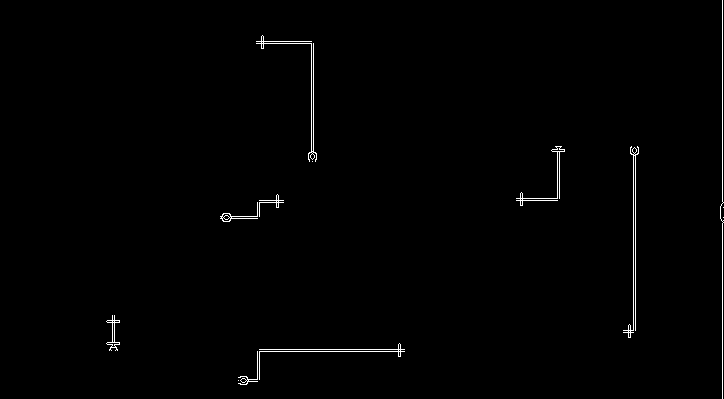

In [9]:
img1, all_lines = apply_hough(img_path=IMG_PATH, tablas=tablas)

In [10]:
from copy import deepcopy

final_lines = []
main_flag = False
i = 0

while not main_flag:
    popped_start = False
    popped_end = False
    
    if i == 0:
        k,v = next(iter(all_lines.items()))
        all_lines_aux = deepcopy(all_lines)
        all_lines_aux.pop(k)
    else:
        k,v = next(iter(all_lines_aux.items()))
        all_lines_aux.pop(k)
        
    without_current = {}
    for k2,v2 in all_lines_aux.items():
        without_current[k2+"_start"] = v2[0]
        without_current[k2+"_end"] = v2[1]

    flag = False
    while not flag:
        start = v[0]
        end = v[1]

        if len(without_current)==0:
            break
        
        new_start, unify_start = get_key_to_unify(point=start, points=without_current)
        new_end, unify_end = get_key_to_unify(point=end, points=without_current)

        new_start, new_end = validate_points(start, end, new_start, new_end)

        v[0], v[1] = new_start, new_end  

        if unify_start is not None:
            print(f"Popped start {unify_start}")
            without_current.pop(unify_start+"_start")
            without_current.pop(unify_start+"_end")
            element = all_lines_aux.pop(unify_start)
            popped_start = True
        elif unify_end is not None:
            print(f"Popped end {unify_end}")
            without_current.pop(unify_end+"_start")
            without_current.pop(unify_end+"_end")
            element = all_lines_aux.pop(unify_end)
            popped_end = True
        
        # Si no se actualizó el start y el end, seguimos
        if not (popped_start or popped_end):
            flag = True

        popped_start = False
        popped_end = False
        
    final_lines.append([v[0], v[1]])
    to_delete = delete_stuck_points(line=[v[0], v[1]], lines_dict=all_lines_aux)
    for el in to_delete:
        all_lines_aux.pop(el)
        
    main_flag = len(all_lines_aux.keys()) < 2
    i += 1
    print(f"Finished detecting line!")

Popped start 420
Popped start 190
Finished detecting line!
Popped start 20
Popped start 120
Popped start 620
Popped end 440
Popped end 490
Popped end 580
Popped end 660
Finished detecting line!
Popped start 40
Popped start 150
Popped start 280
Popped end 610
Finished detecting line!
Popped start 520
Popped start 80
Popped start 60
Popped start 200
Popped start 430
Popped start 460
Finished detecting line!
Popped start 140
Popped end 90
Popped end 220
Finished detecting line!
Popped start 160
Popped start 260
Popped start 270
Popped start 230
Popped start 250
Popped start 480
Popped start 550
Popped start 210
Popped start 390
Popped end 540
Popped end 330
Finished detecting line!
Popped start 130
Popped start 360
Popped start 310
Popped start 530
Popped start 590
Popped end 290
Popped end 180
Popped end 400
Finished detecting line!
Popped start 370
Popped start 320
Popped start 630
Popped start 570
Popped start 510
Popped start 560
Finished detecting line!
Popped start 470
Popped start 

In [11]:
final_lines

[[[722, 201], [722, 0]],
 [[630, 147], [630, 337]],
 [[259, 349], [400, 356]],
 [[256, 41], [311, 43]],
 [[722, 236], [722, 398]],
 [[220, 216], [278, 207]],
 [[552, 149], [557, 198]],
 [[107, 344], [117, 349]],
 [[522, 205], [528, 198]],
 [[243, 382], [257, 381]],
 [[308, 154], [314, 156]]]

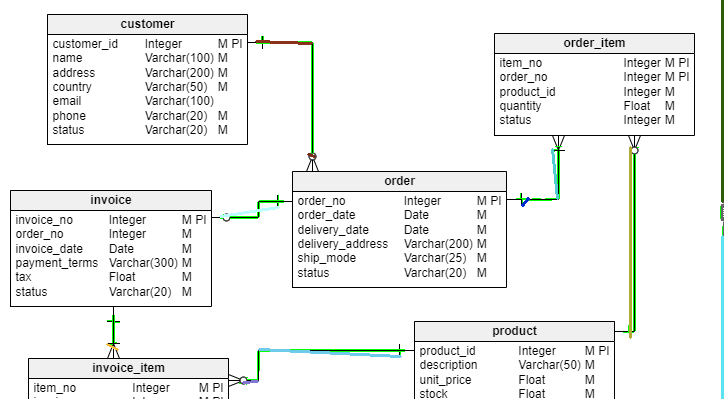

In [12]:
import random

for l in final_lines:
    pts = np.array(l, np.int32)
    img1 = np.array(img1)
    random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.polylines(img1, [pts], True, random_color, 2)
Image.fromarray(img1)